<a href="https://colab.research.google.com/github/sarapersson/mario-rl-ppo/blob/main/Mario_RL_PPO_Local_TrainingSuite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mario PPO - Local Training Suite

This notebook trains a PPO agent (Stable-Baselines3, PyTorch) to play Super Mario Bros locally in Colab
(no cloud storage required). Observations use 84x84 grayscale frames. Reward modes:
- "spec" (default): +1 when forward progress occurs in a step, -15 on death, else 0 (matches project spec)
- "shaped": dense progress shaping (+dx), step penalty, checkpoints, and death penalty

Default action set: SIMPLE_MOVEMENT (7 actions).

**Contents**
- A0) Runtime hygiene and warning filters
- A1) Pin NumPy version (requires runtime restart)
- A2) Install dependencies
- A3) Version information
- B-LOCAL) Local storage in /content (no cloud)
- C) Environment tools and wrappers (84x84 grayscale, reward mode toggle)
- C1) Configuration panel
- C2) Sanity check
- C3) Action sets
- D0) Hardware information
- D) Training with auto-resume (warmup plus blocks)
- T) Quick test (short training)
- E) Learning analysis (reward curve)
- F1) Video: trained model (60 s)
- F2) Video: random agent (15 s)
- G) Report generator (1–2 pages, covers all required points)
- H) Export and import helpers
- S-STATUS) Status overview (local artifacts)
- S-SIZE) Size overview
- S-LOCAL) Export - full bundle (ZIP)
- S-LOCAL-LITE) Export - minimal bundle (ZIP)
- J) Evaluation (N episodes)
- J2) Evaluation with explicit distance (N episodes)
- U-LOCAL-PACK) Prepare GitHub-ready zip (NO tokens)
- P) Cleanup


## A0) Runtime hygiene and warning filters

In [ ]:

import os, warnings
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore', category=UserWarning, message='.*deprecated.*')
print('Runtime hygiene and conservative settings have been applied.')


Runtime hygiene and conservative settings have been applied.


## A1) Pin NumPy version (requires runtime restart)

In [ ]:

# Pin NumPy to 1.26.4 to avoid ABI issues with older RL and game libraries.
!python -m pip uninstall -y numpy nes-py gym-super-mario-bros gym gymnasium stable-baselines3 shimmy
!python -m pip uninstall -y tensorflow tensorboard tensorboard-data-server tensorflow-estimator tensorflow-io-gcs-filesystem || true
!python -m pip install --no-cache-dir numpy==1.26.4
import numpy as np; print('NumPy version:', np.__version__)
print('Please restart the runtime now: Runtime -> Restart session. After restarting, continue with section A2.')


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: gymnasium 1.2.2
Uninstalling gymnasium-1.2.2:
  Successfully uninstalled gymnasium-1.2.2
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: tensorboard 2.19.0
Uninstalling tensorboard-2.19.0:
  Successfully uninstalled tensorboard-2.19.0
Found existing installation: tensorboard-data-server 0.7.2
Uninstalling tensorboard-data-server-0.7.2:
  Successfully uninstalled tensorboard-data-server-0.7.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 147.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 341.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are insta

## A2) Install dependencies

In [ ]:

!python -m pip install -U --no-cache-dir \
  stable-baselines3 \
  gymnasium==0.29.1 shimmy \
  gym==0.26.2 \
  nes-py==8.2.1 gym-super-mario-bros==7.4.0 \
  imageio imageio-ffmpeg moviepy pillow markdown pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 97.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 206.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 343.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 253.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 387.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 432.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 363.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 240.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## A3) Version information

In [ ]:

import numpy, gym, gymnasium, stable_baselines3, torch
print('NumPy:', numpy.__version__)
print('Gym:', gym.__version__)
print('Gymnasium:', gymnasium.__version__)
print('Stable-Baselines3:', stable_baselines3.__version__)
print('PyTorch CUDA available:', torch.cuda.is_available())


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


NumPy: 1.26.4
Gym: 0.26.2
Gymnasium: 0.29.1
Stable-Baselines3: 2.7.0
PyTorch CUDA available: True


## B-LOCAL) Local storage in /content (no cloud)

In [ ]:

from pathlib import Path
base_dir = "/content/mario_rl_local"
for p in ("logs","models","models/exports","videos","plots","reports"):
    Path(f"{base_dir}/{p}").mkdir(parents=True, exist_ok=True)
BASE = base_dir
print('Local storage has been initialized at:', base_dir)


Local storage has been initialized at: /content/mario_rl_local


## C) Environment tools and wrappers (84x84 grayscale, reward mode toggle)

In [ ]:

# Environment wrappers and utilities
# - 84x84 grayscale frames (channel last)
# - Frame skip and action repeat
# - Reward modes: "spec" (default) or "shaped"
# - Early stop on stagnation and max episode length cap
# - Compatibility fixes for nes-py overflow and JoypadSpace.reset kwargs

import os, numpy as np, torch, torch.nn as nn
from PIL import Image

import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT

import gymnasium as gymn
from gymnasium import spaces as gspaces

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import (
    DummyVecEnv, SubprocVecEnv, VecFrameStack, VecTransposeImage, VecEnvWrapper
)
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env

# Default reward mode and action set
REWARD_MODE = "spec"   # "spec" or "shaped"

# nes-py overflow hotfix
try:
    import nes_py._rom as _rom
    def _kb(x): return int(x) * (1<<10)
    _rom.Rom.prg_rom_stop = property(lambda self: int(self.prg_rom_start) + _kb(self.prg_rom_size))
    if hasattr(_rom.Rom,'chr_rom_stop'):
        _rom.Rom.chr_rom_stop = property(lambda self: int(self.chr_rom_start) + _kb(self.chr_rom_size))
    print('nes-py overflow hotfix active.')
except Exception as e:
    print('Info: nes-py hotfix could not be applied:', e)

def convert_spaces_to_gymnasium(env):
    if not isinstance(env.observation_space, gspaces.Space):
        os_ = env.observation_space
        env.observation_space = gspaces.Box(low=0, high=255, shape=os_.shape, dtype=np.uint8)
    if not isinstance(env.action_space, gspaces.Space):
        a = env.action_space
        if getattr(a, 'n', None) is not None:
            env.action_space = gspaces.Discrete(a.n)
    return env

class DropResetKwargs(gymn.Wrapper):
    def reset(self, *args, **kwargs):
        kwargs.pop('seed', None); kwargs.pop('options', None)
        out = self.env.reset()
        return out if (isinstance(out, tuple) and len(out)==2) else (out, {})

class GrayscaleResize84(gymn.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env); self.observation_space = gspaces.Box(0,255,shape=(84,84,1),dtype=np.uint8)
    def observation(self, obs):
        arr = np.array(Image.fromarray(obs).convert('L').resize((84,84)), dtype=np.uint8)
        return arr[...,None]

class FrameSkip(gymn.Wrapper):
    def __init__(self, env, frame_skip=4): super().__init__(env); self.frame_skip=frame_skip
    def step(self, a):
        R=0.0; inf={}; d=t=False
        for _ in range(self.frame_skip):
            o,r,d,t,inf = self.env.step(a); R+=r
            if d or t: break
        return o,R,d,t,inf

class ActionRepeatWrapper(gymn.Wrapper):
    def __init__(self, env, action_repeat=2): super().__init__(env); self.action_repeat=action_repeat
    def step(self, a):
        R=0.0; inf={}; d=t=False
        for _ in range(self.action_repeat):
            o,r,d,t,inf = self.env.step(a); R+=r
            if d or t: break
        return o,R,d,t,inf

class MaxStepsWrapper(gymn.Wrapper):
    def __init__(self, env, max_steps=3000): super().__init__(env); self.max_steps=max_steps; self.t=0
    def reset(self, **kw): self.t=0; return super().reset(**kw)
    def step(self, a):
        o,r,d,t,inf = self.env.step(a); self.t+=1
        if self.t>=self.max_steps and not (d or t):
            t=True; inf=dict(inf); inf['TimeLimit.truncated']=True
        return o,r,d,t,inf

class StagnationEarlyStop(gymn.Wrapper):
    def __init__(self, env, patience=120): super().__init__(env); self.p=patience; self.prev=0; self.no=0
    def reset(self, **kw): out=super().reset(**kw); self.prev=0; self.no=0; return out
    def step(self, a):
        o,r,d,t,inf = self.env.step(a); x=inf.get('x_pos',0)
        if x>self.prev: self.no=0; self.prev=x
        else:
            self.no+=1
            if self.no>=self.p and not (d or t):
                t=True; inf=dict(inf); inf['EarlyStop.stagnation']=True
        return o,r,d,t,inf

class DeathPenaltyReward(gymn.Wrapper):
    def step(self, a):
        o,r,d,t,inf = self.env.step(a)
        if d and not inf.get('flag_get'): r -= 15.0
        return o,r,d,t,inf

class ProgressShapingReward(gymn.Wrapper):
    def __init__(self, env, progress_coef=0.5, per_step_penalty=0.01, progress_checkpoints=(120,300,700), checkpoint_bonus=(5.0,8.0,12.0)):
        super().__init__(env)
        self.c=progress_coef; self.ps=per_step_penalty
        self.ck=list(progress_checkpoints); self.cb=list(checkpoint_bonus)
        self.hit=None; self.prev=0
    def reset(self, **kw): out=super().reset(**kw); self.hit=[False]*len(self.ck); self.prev=0; return out
    def step(self, a):
        o,r,d,t,inf = self.env.step(a); x=inf.get('x_pos',0); dx=max(0,x-self.prev)
        shaped = r + self.c*dx - self.ps
        for i,g in enumerate(self.ck):
            if not self.hit[i] and self.prev < g <= x:
                shaped += self.cb[i]; self.hit[i]=True
        self.prev=x; return o,shaped,d,t,inf

class SpecReward(gymn.Wrapper):
    def __init__(self, env):
        super().__init__(env); self.prev_x = 0
    def reset(self, **kw):
        obs, info = self.env.reset()
        self.prev_x = info.get('x_pos', 0)
        return obs, info
    def step(self, a):
        o, r, d, t, inf = self.env.step(a)
        x = inf.get('x_pos', 0); dx = max(0, x - self.prev_x)
        shaped = 1.0 if dx > 0 else 0.0
        if d and not inf.get('flag_get', False):
            shaped -= 15.0
        self.prev_x = x
        return o, shaped, d, t, inf

class SmallCNNFeatures(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=128):
        super().__init__(observation_space, features_dim); C = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(C,16,8,4), nn.ReLU(),
            nn.Conv2d(16,32,4,2), nn.ReLU(),
            nn.Flatten()
        )
        with torch.no_grad(): n_flat = self.cnn(torch.zeros(1,C,84,84)).shape[1]
        self.linear = nn.Sequential(nn.Linear(n_flat, features_dim), nn.ReLU())
    def forward(self, x): return self.linear(self.cnn(x.float()/255.0))

def make_env_compact(render_mode=None, action_set='SIMPLE_MOVEMENT', frame_skip=4, action_repeat=2):
    e = gym_super_mario_bros.make('SuperMarioBros-1-1-v3', apply_api_compatibility=True, render_mode=render_mode)
    e = JoypadSpace(e, RIGHT_ONLY if action_set=='RIGHT_ONLY' else SIMPLE_MOVEMENT)
    e = ActionRepeatWrapper(e, action_repeat=action_repeat)
    e = FrameSkip(e, frame_skip=frame_skip)
    e = GrayscaleResize84(e)
    e = MaxStepsWrapper(e, 3000)
    e = StagnationEarlyStop(e, 120)
    if REWARD_MODE == "spec":
        e = SpecReward(e)
    else:
        e = ProgressShapingReward(e, progress_coef=0.5, per_step_penalty=0.01,
                                  progress_checkpoints=(120,300,700), checkpoint_bonus=(5,8,12))
        e = DeathPenaltyReward(e)
    e = convert_spaces_to_gymnasium(e)
    e = Monitor(e)
    e = DropResetKwargs(e)
    return e

class VecDropResetKwargs(VecEnvWrapper):
    def reset(self, **kwargs):
        kwargs.pop("seed", None); kwargs.pop("options", None)
        try: return self.venv.reset(**kwargs)
        except TypeError: return self.venv.reset()
    def step_async(self, actions): return self.venv.step_async(actions)
    def step_wait(self): return self.venv.step_wait()

def make_vector_env(num_envs, log_dir, render_mode=None, action_set='SIMPLE_MOVEMENT', frame_skip=4, action_repeat=2, frame_stack=2, prefer_subproc=True):
    if prefer_subproc and num_envs>1:
        try:
            v = make_vec_env(make_env_compact, n_envs=num_envs, vec_env_cls=SubprocVecEnv, monitor_dir=log_dir,
                             env_kwargs=dict(render_mode=render_mode, action_set=action_set, frame_skip=frame_skip, action_repeat=action_repeat))
            print(f'SubprocVecEnv created: {num_envs}')
        except Exception as e:
            print('Info: SubprocVecEnv failed, falling back to DummyVecEnv:', e)
            v = make_vec_env(make_env_compact, n_envs=num_envs, vec_env_cls=DummyVecEnv, monitor_dir=log_dir,
                             env_kwargs=dict(render_mode=render_mode, action_set=action_set, frame_skip=frame_skip, action_repeat=action_repeat))
            print(f'DummyVecEnv created: {num_envs}')
    else:
        v = make_vec_env(make_env_compact, n_envs=1, vec_env_cls=DummyVecEnv, monitor_dir=log_dir,
                         env_kwargs=dict(render_mode=render_mode, action_set=action_set, frame_skip=frame_skip, action_repeat=action_repeat))
        print('DummyVecEnv created: 1')
    v = VecFrameStack(v, n_stack=frame_stack, channels_order="last"); v = VecTransposeImage(v)
    try:
        v = VecDropResetKwargs(v); print("VecDropResetKwargs active.")
    except Exception as e:
        print("Info: VecDropResetKwargs could not be activated:", e)
    return v

# Patch JoypadSpace.reset to ignore seed and options kwargs
if not getattr(JoypadSpace.reset, "_patched_ignore_seed", False):
    _orig_reset = JoypadSpace.reset
    def _reset_ignore_seed(self, *args, **kwargs):
        kwargs.pop("seed", None); kwargs.pop("options", None)
        return _orig_reset(self)
    _reset_ignore_seed._patched_ignore_seed = True
    JoypadSpace.reset = _reset_ignore_seed
    print("JoypadSpace.reset patched to ignore seed/options.")

print('Environment utilities initialized. REWARD_MODE =', REWARD_MODE)


Info: nes-py hotfix could not be applied: module 'nes_py._rom' has no attribute 'Rom'
JoypadSpace.reset patched to ignore seed/options.
Environment utilities initialized. REWARD_MODE = spec


## C1) Configuration panel

In [ ]:

action_set    = 'SIMPLE_MOVEMENT'  # 'SIMPLE_MOVEMENT' (default) or 'RIGHT_ONLY'
num_envs      = 1
frame_stack   = 2
action_repeat = 2
frame_skip    = 4
print('Configuration:',
      'action_set =', action_set,
      '| num_envs =', num_envs,
      '| frame_stack =', frame_stack,
      '| action_repeat =', action_repeat,
      '| frame_skip(warmup) =', frame_skip,
      '| reward_mode =', REWARD_MODE)


Configuration: action_set = SIMPLE_MOVEMENT | num_envs = 1 | frame_stack = 2 | action_repeat = 2 | frame_skip(warmup) = 4 | reward_mode = spec


## C2) Sanity check

In [ ]:

venv = make_vector_env(1, f"{base_dir}/logs/_sanity", render_mode=None,
                       action_set=('RIGHT_ONLY' if action_set=='RIGHT_ONLY' else 'SIMPLE_MOVEMENT'),
                       frame_skip=frame_skip, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
print('Observation space:', venv.observation_space, '| Action space:', venv.action_space)
venv.close(); print('Sanity check completed.')


DummyVecEnv created: 1
VecDropResetKwargs active.
Observation space: Box(0, 255, (2, 84, 84), uint8) | Action space: Discrete(7)
Sanity check completed.


/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.spec to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.spec` for environment variables or `env.get_wrapper_attr('spec')` that will search the reminding wrappers.
  logger.warn(


## C3) Action sets

In [ ]:

from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT
print('RIGHT_ONLY (n = 5):', RIGHT_ONLY)
print('SIMPLE_MOVEMENT (n = 7):', SIMPLE_MOVEMENT)


RIGHT_ONLY (n = 5): [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]
SIMPLE_MOVEMENT (n = 7): [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]


## D0) Hardware information

In [ ]:

import torch, shutil, subprocess
print('PyTorch CUDA availability:', torch.cuda.is_available())
if shutil.which('nvidia-smi'):
    print(subprocess.run(['nvidia-smi','-L'], capture_output=True, text=True).stdout.strip())
    print(subprocess.run(['nvidia-smi'], capture_output=True, text=True).stdout.splitlines()[0])
print('Selected device:', 'cuda' if torch.cuda.is_available() else 'cpu')


PyTorch CUDA availability: True
GPU 0: Tesla T4 (UUID: GPU-53b67c7a-e7c4-aa4f-3655-a6c8f4728b61)
Sun Nov 16 23:44:09 2025       
Selected device: cuda


## D) Training with auto-resume (warmup plus blocks)

In [ ]:

from pathlib import Path
from datetime import datetime
from shutil import copy2
import os, json, numpy as np, random, warnings, torch
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
warnings.filterwarnings("ignore", category=UserWarning, message=r".*env\.spec.*deprecated.*")

def find_latest_export_zip(base_dir_str):
    base = Path(base_dir_str)
    if not base.exists(): return None
    exp = sorted((base/"models"/"exports").glob("*.zip"), key=lambda p: p.stat().st_mtime, reverse=True)
    if exp: return str(exp[0])
    runs = sorted((base/"models").glob("*"), key=lambda p: p.stat().st_mtime, reverse=True)
    for r in runs:
        bm = r / "best_model.zip"
        if bm.exists(): return str(bm)
    zips = sorted((base/"models").glob("*/*.zip"), key=lambda p: p.stat().st_mtime, reverse=True)
    return str(zips[0]) if zips else None

def model_meta_path(zip_path):
    return Path(zip_path).with_suffix(".meta.json")

def read_model_meta(zip_path):
    mp = model_meta_path(zip_path)
    if mp.exists():
        try: return json.loads(mp.read_text())
        except Exception: pass
    return None

def write_model_meta(zip_path, action_set, frame_stack, action_repeat, reward_mode):
    mp = model_meta_path(zip_path)
    mp.write_text(json.dumps(dict(action_set=action_set,
                                  frame_stack=int(frame_stack),
                                  action_repeat=int(action_repeat),
                                  reward_mode=str(reward_mode)), indent=2), encoding="utf-8")
    print("Model metadata written:", mp.name)

def export_model_copy(src_path, tag, base_dir_str, run_id):
    dst = Path(base_dir_str)/"models"/"exports"/f"{run_id}_{tag}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.zip"
    copy2(src_path, dst); print("Model exported:", dst.name); return str(dst)

def infer_action_set_from_model(zip_path):
    m = read_model_meta(zip_path)
    if m and m.get("action_set") in ("RIGHT_ONLY","SIMPLE_MOVEMENT"):
        print("Action set from metadata:", m["action_set"]); return m["action_set"]
    tmp = PPO.load(zip_path, device="cpu"); n_act = tmp.action_space.n
    det = "RIGHT_ONLY" if n_act==5 else ("SIMPLE_MOVEMENT" if n_act==7 else None)
    print("Action set inferred from action space:", det); return det

def make_training_bundle(frame_skip_used, ent_coef, action_set_used, num_envs, log_dir, action_repeat, frame_stack):
    venv     = make_vector_env(num_envs, log_dir, None, action_set=action_set_used, frame_skip=frame_skip_used, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=(num_envs>1))
    eval_env = make_vector_env(1,       log_dir, None, action_set=action_set_used, frame_skip=frame_skip_used, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
    policy_kwargs = dict(features_extractor_class=SmallCNNFeatures, features_extractor_kwargs=dict(features_dim=128), net_arch=[128, 128])
    model = PPO("CnnPolicy", venv, policy_kwargs=policy_kwargs, n_steps=256, batch_size=512, n_epochs=3,
                learning_rate=3e-4, gamma=0.999, gae_lambda=0.95, clip_range=0.2, ent_coef=ent_coef, vf_coef=0.5,
                device=("cuda" if torch.cuda.is_available() else "cpu"), verbose=1, seed=42)
    eval_cb = EvalCallback(eval_env, best_model_save_path=model_dir, log_path=log_dir, eval_freq=60000, n_eval_episodes=3, deterministic=True)
    return model, venv, eval_env, eval_cb

def learn_with_restart(model, total_timesteps, eval_cb, frame_skip_used, phase_tag, action_set_used, log_dir, action_repeat, frame_stack):
    start = getattr(model, "num_timesteps", 0)
    try:
        model.learn(total_timesteps=total_timesteps, reset_num_timesteps=False, callback=eval_cb)
        return
    except (EOFError, BrokenPipeError, ConnectionResetError) as e:
        print(f"{phase_tag}: worker crashed ({type(e).__name__}), attempting restart.")
        try:
            old_env = model.get_env(); n_model_envs = getattr(old_env, "num_envs", 1)
        except Exception:
            n_model_envs = 1
        try: model.get_env().close()
        except Exception: pass
        train_re = make_vector_env(n_model_envs, log_dir, None, action_set=action_set_used, frame_skip=frame_skip_used, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
        eval_re  = make_vector_env(1, log_dir, None, action_set=action_set_used, frame_skip=frame_skip_used, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
        model.set_env(train_re)
        cb2 = EvalCallback(eval_re, best_model_save_path=model_dir, log_path=log_dir, eval_freq=60000, n_eval_episodes=3, deterministic=True)
        done_so_far = max(0, getattr(model, "num_timesteps", 0) - start)
        remaining   = max(0, total_timesteps - done_so_far)
        if remaining > 0:
            model.learn(total_timesteps=remaining, reset_num_timesteps=False, callback=cb2)
        try: train_re.close(); eval_re.close()
        except Exception: pass

from pathlib import Path
run_id  = datetime.now().strftime("ppo_local_%Y%m%d_%H%M%S")
log_dir   = f"{base_dir}/logs/{run_id}"
model_dir = f"{base_dir}/models/{run_id}"
for d in (log_dir, model_dir): Path(d).mkdir(parents=True, exist_ok=True)
Path(f"{base_dir}/models/exports").mkdir(parents=True, exist_ok=True)

import random
np.random.seed(42); random.seed(42); torch.manual_seed(42)

num_blocks           = 2
timesteps_per_block  = 30000
warmup_timesteps     = 10000
warmup_frame_skip    = int(globals().get('frame_skip',4))
warmup_ent_coef      = 0.02

resume_zip = find_latest_export_zip(base_dir)
if resume_zip is not None:
    det = infer_action_set_from_model(resume_zip)
    if det and det != globals().get('action_set'):
        print("Notebook action_set differs from model; switching notebook to model action_set.")
        action_set = det

if resume_zip is None:
    print(f"Warmup: frame_skip={warmup_frame_skip}, ent_coef={warmup_ent_coef}, action_set={action_set}, reward_mode={REWARD_MODE}.")
    model, venv, eval_env, eval_cb = make_training_bundle(warmup_frame_skip, warmup_ent_coef, action_set, num_envs, log_dir, action_repeat, frame_stack)
    learn_with_restart(model, warmup_timesteps, eval_cb, warmup_frame_skip, "warmup", action_set, log_dir, action_repeat, frame_stack)
    ckpt_boot = Path(model_dir)/"ckpt_bootstrap.zip"; model.save(str(ckpt_boot)); print("Warmup checkpoint saved:", ckpt_boot.name)
    resume_zip = export_model_copy(ckpt_boot, "bootstrap", base_dir, run_id)
    write_model_meta(resume_zip, action_set, frame_stack, action_repeat, REWARD_MODE)
    try: venv.close(); eval_env.close()
    except Exception: pass

for b in range(1, num_blocks + 1):
    print(f"=== Training block {b}/{num_blocks} from {Path(resume_zip).name} | ACTION_SET={action_set} | REWARD_MODE={REWARD_MODE} ===")
    train_env = make_vector_env(num_envs, log_dir, None, action_set=action_set, frame_skip=2, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=(num_envs>1))
    eval_env  = make_vector_env(1,       log_dir, None, action_set=action_set, frame_skip=2, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
    model = PPO.load(resume_zip, env=train_env, device=("cuda" if torch.cuda.is_available() else "cpu"))
    model.ent_coef = 0.01
    eval_cb = EvalCallback(eval_env, best_model_save_path=model_dir, log_path=log_dir, eval_freq=60000, n_eval_episodes=3, deterministic=True)
    learn_with_restart(model, timesteps_per_block, eval_cb, 2, f"block-{b}", action_set, log_dir, action_repeat, frame_stack)
    ckpt = Path(model_dir) / f"ckpt_auto_{b}.zip"; model.save(str(ckpt)); print("Checkpoint saved:", ckpt.name)
    best_zip = Path(model_dir) / "best_model.zip"; src = best_zip if best_zip.exists() else ckpt
    resume_zip = export_model_copy(src, f"auto_best_b{b:02d}", base_dir, run_id)
    write_model_meta(resume_zip, action_set, frame_stack, action_repeat, REWARD_MODE)
    try: train_env.close(); eval_env.close()
    except Exception: pass

print("Training complete.")


## T) Quick test (short training)

In [ ]:

from pathlib import Path
from datetime import datetime
from shutil import copy2
import os, json, numpy as np, random, warnings, torch
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
warnings.filterwarnings("ignore", category=UserWarning, message=r".*env\.spec.*deprecated.*")

TEST = dict(action_set='SIMPLE_MOVEMENT', num_envs=1, frame_stack=2, action_repeat=2,
            frame_skip=4, warmup_timesteps=3000, num_blocks=1, timesteps_per_block=8000,
            warmup_ent=0.02, main_ent=0.01, eval_freq=2000)

frame_stack   = int(TEST.get('frame_stack',2))
action_repeat = int(TEST.get('action_repeat',2))
frame_skip    = int(TEST.get('frame_skip',4))
EVALF         = int(TEST.get('eval_freq',2000))
SEED=42; random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

run_id  = datetime.now().strftime("ppo_quick_%Y%m%d_%H%M%S")
log_dir   = f"{base_dir}/logs/{run_id}"
model_dir = f"{base_dir}/models/{run_id}"
for d in (log_dir, model_dir): Path(d).mkdir(parents=True, exist_ok=True)
Path(f"{base_dir}/models/exports").mkdir(parents=True, exist_ok=True)

def write_model_meta(zip_path, action_set, frame_stack, action_repeat, reward_mode):
    mp = Path(zip_path).with_suffix(".meta.json")
    mp.write_text(json.dumps(dict(action_set=action_set,
                                  frame_stack=int(frame_stack),
                                  action_repeat=int(action_repeat),
                                  reward_mode=str(reward_mode)), indent=2), encoding="utf-8")
    print("Model metadata written:", mp.name)

def make_training_bundle(frame_skip_used, ent_coef, eval_freq, action_set_used):
    venv     = make_vector_env(1, log_dir, None, action_set=action_set_used, frame_skip=frame_skip_used, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
    eval_env = make_vector_env(1, log_dir, None, action_set=action_set_used, frame_skip=frame_skip_used, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
    policy_kwargs = dict(features_extractor_class=SmallCNNFeatures, features_extractor_kwargs=dict(features_dim=128), net_arch=[128,128])
    model = PPO('CnnPolicy', venv, policy_kwargs=policy_kwargs, n_steps=256, batch_size=256, n_epochs=3,
                learning_rate=3e-4, gamma=0.999, gae_lambda=0.95, clip_range=0.2, ent_coef=ent_coef, vf_coef=0.5,
                device=('cuda' if torch.cuda.is_available() else 'cpu'), verbose=1, seed=SEED)
    eval_cb = EvalCallback(eval_env, best_model_save_path=model_dir, log_path=log_dir, eval_freq=eval_freq, n_eval_episodes=2, deterministic=True)
    return model, venv, eval_env, eval_cb

print(f"Warmup: {TEST['warmup_timesteps']} steps, frame_skip={frame_skip}, ent={TEST['warmup_ent']}, reward_mode={REWARD_MODE}.")
model, venv, eval_env, eval_cb = make_training_bundle(frame_skip, TEST['warmup_ent'], EVALF, TEST['action_set'])
model.learn(total_timesteps=TEST['warmup_timesteps'], reset_num_timesteps=False, callback=eval_cb)
ckpt = Path(model_dir)/'ckpt_bootstrap.zip'; model.save(str(ckpt)); print('Warmup checkpoint saved:', ckpt.name)
dst = (Path(base_dir)/'models'/'exports'/f"{run_id}_bootstrap.zip"); copy2(ckpt, dst); print("Warmup model exported:", dst.name)
write_model_meta(str(dst), TEST['action_set'], frame_stack, action_repeat, REWARD_MODE)
try: venv.close(); eval_env.close()
except: pass

print(f"Main quick pass: {TEST['timesteps_per_block']} steps, frame_skip=2, ent={TEST['main_ent']}.")
train_env = make_vector_env(1, log_dir, None, action_set=TEST['action_set'], frame_skip=2, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
eval_env  = make_vector_env(1, log_dir, None, action_set=TEST['action_set'], frame_skip=2, action_repeat=action_repeat, frame_stack=frame_stack, prefer_subproc=False)
model = PPO.load(str(dst), env=train_env, device=('cuda' if torch.cuda.is_available() else 'cpu')); model.ent_coef = TEST['main_ent']
eval_cb = EvalCallback(eval_env, best_model_save_path=model_dir, log_path=log_dir, eval_freq=EVALF, n_eval_episodes=3, deterministic=True)
model.learn(total_timesteps=TEST['timesteps_per_block'], reset_num_timesteps=False, callback=eval_cb)
best_zip = Path(model_dir)/'best_model.zip'
src = best_zip if best_zip.exists() else (Path(model_dir)/'ckpt_quick.zip'); model.save(str(src)); print('Quick-pass checkpoint saved:', src.name)
dst2 = (Path(base_dir)/'models'/'exports'/f"{run_id}_quick_best.zip"); copy2(src, dst2); print("Quick-pass best exported:", dst2.name)
(Path(str(dst2))).with_suffix(".meta.json").write_text(json.dumps(dict(action_set=TEST['action_set'], frame_stack=frame_stack, action_repeat=action_repeat, reward_mode=REWARD_MODE), indent=2), encoding='utf-8')
print('Quick test complete.')


Warmup: 3000 steps, frame_skip=4, ent=0.02, reward_mode=spec.
DummyVecEnv created: 1
VecDropResetKwargs active.
DummyVecEnv created: 1
VecDropResetKwargs active.
Using cuda device


/usr/local/lib/python3.12/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 65.5     |
|    ep_rew_mean     | 34.5     |
| time/              |          |
|    fps             | 32       |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 256      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 94            |
|    ep_rew_mean          | 51.7          |
| time/                   |               |
|    fps                  | 35            |
|    iterations           | 2             |
|    time_elapsed         | 14            |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 2.1234155e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 5.92e-05      |


## E) Learning analysis (reward curve)

Selected log directory: /content/mario_rl_local/logs/ppo_quick_20251116_234415


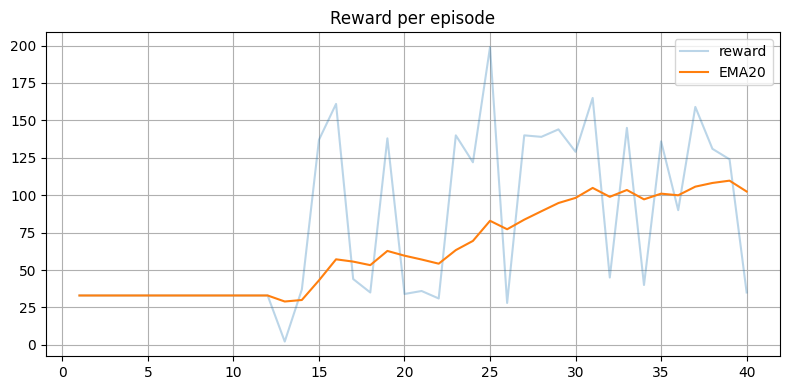

Episode count: 40
Mean reward over the last 20 episodes: 108.9
Total timesteps from logs (sum of l): 5961


In [ ]:

from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt

def find_latest_log_dir(base_logs):
    mfiles = sorted(Path(base_logs).glob('**/*.monitor.csv'), key=lambda p: p.stat().st_mtime, reverse=True)
    return mfiles[0].parent if mfiles else None

_ld = find_latest_log_dir(f"{base_dir}/logs"); assert _ld, 'No log directory was found.'
log_dir = str(_ld); print('Selected log directory:', log_dir)
files = sorted(Path(log_dir).glob('**/*.monitor.csv'))
df = pd.concat([pd.read_csv(f, comment='#') for f in files], ignore_index=True).reset_index(drop=True)
df['episode'] = range(1, len(df)+1); df['ema20'] = df['r'].ewm(span=20).mean()
plt.figure(figsize=(8,4)); plt.plot(df['episode'], df['r'], alpha=0.3, label='reward'); plt.plot(df['episode'], df['ema20'], label='EMA20')
plt.legend(); plt.title('Reward per episode'); plt.grid(True); plt.tight_layout(); plt.show()
print('Episode count:', len(df))
print('Mean reward over the last 20 episodes:', float(df['r'].tail(20).mean()))
print('Total timesteps from logs (sum of l):', int(df['l'].sum()))


## F1) Video: trained model (60 s)

In [ ]:

from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3 import PPO
from pathlib import Path
import json, torch

def find_latest_export_zip(base_dir_str):
    ex = sorted((Path(base_dir_str)/'models'/'exports').glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)
    return str(ex[0]) if ex else None

def model_meta_path(zip_path):
    return Path(zip_path).with_suffix('.meta.json')

def infer_action_set_from_model(zip_path):
    mp = model_meta_path(zip_path)
    if mp.exists():
        try:
            m = json.loads(mp.read_text())
            if m.get('action_set') in ('RIGHT_ONLY','SIMPLE_MOVEMENT'):
                print('Action set (metadata):', m['action_set'])
                return m['action_set']
        except Exception:
            pass
    tmp = PPO.load(zip_path, device='cpu')
    n_act = tmp.action_space.n
    return 'RIGHT_ONLY' if n_act == 5 else 'SIMPLE_MOVEMENT'

model_zip = find_latest_export_zip(base_dir); assert model_zip, 'No exported model was found.'
action_set_play  = infer_action_set_from_model(model_zip)
frame_stack_play = int(globals().get('frame_stack',2))
action_repeat_play = int(globals().get('action_repeat',2))

play_env = make_vector_env(1, f"{base_dir}/logs/_play", render_mode='rgb_array',
                           action_set=action_set_play, frame_skip=2, action_repeat=action_repeat_play, frame_stack=frame_stack_play, prefer_subproc=False)
try:
    RENDER_FPS = play_env.get_attr('metadata')[0].get('render_fps',30)
except Exception:
    RENDER_FPS = 30

VIDEO_SECONDS=60; VIDEO_STEPS=int(RENDER_FPS*VIDEO_SECONDS)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PPO.load(model_zip, env=play_env, device=device)

p=Path(model_zip)
VIDEO_DIR=p.parent.as_posix().replace('/models/','/videos/') if '/models/' in p.as_posix() else f'{base_dir}/videos'
Path(VIDEO_DIR).mkdir(parents=True, exist_ok=True)

video_env = VecVideoRecorder(play_env, VIDEO_DIR, record_video_trigger=lambda step: step==0, video_length=VIDEO_STEPS, name_prefix=f'play_{p.stem}')
obs = video_env.reset(); steps=0
while steps<VIDEO_STEPS:
    a,_=model.predict(obs, deterministic=True); obs,_,done,_=video_env.step(a); steps+=1
    if done.any(): obs=video_env.reset()
try: video_env.close()
except Exception as e: print('Info: video_env.close raised:', e)
try: play_env.close()
except Exception: pass
print('Trained-model video saved in:', VIDEO_DIR)


## F2) Video: random agent (15 s)

In [ ]:

from stable_baselines3.common.vec_env import VecVideoRecorder
from pathlib import Path
import numpy as np, json

def find_latest_export_zip(base_dir_str):
    ex = sorted((Path(base_dir_str)/'models'/'exports').glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)
    return str(ex[0]) if ex else None

def infer_action_set_from_latest(base_dir_str, default='SIMPLE_MOVEMENT'):
    z = find_latest_export_zip(base_dir_str)
    if not z:
        print("No model found. Using default ACTION_SET:", default)
        return default
    mp = Path(z).with_suffix('.meta.json')
    if mp.exists():
        try:
            m = json.loads(mp.read_text())
            if m.get('action_set') in ('RIGHT_ONLY','SIMPLE_MOVEMENT'):
                print('Action set (metadata):', m['action_set'])
                return m['action_set']
        except Exception: pass
    print("Metadata not readable. Using default ACTION_SET:", default)
    return default

action_set_rand  = infer_action_set_from_latest(base_dir, default='SIMPLE_MOVEMENT')
frame_stack_play = int(globals().get('frame_stack',2))
action_repeat_play = int(globals().get('action_repeat',2))

play_env = make_vector_env(1, f"{base_dir}/logs/_random", render_mode='rgb_array',
                           action_set=action_set_rand, frame_skip=4, action_repeat=action_repeat_play, frame_stack=frame_stack_play, prefer_subproc=False)
try:
    RENDER_FPS = play_env.get_attr('metadata')[0].get('render_fps',30)
except Exception:
    RENDER_FPS = 30

VIDEO_SECONDS=15; VIDEO_STEPS=int(RENDER_FPS*VIDEO_SECONDS)
VIDEO_DIR=f"{base_dir}/videos/_random"; Path(VIDEO_DIR).mkdir(parents=True, exist_ok=True)

video_env = VecVideoRecorder(play_env, VIDEO_DIR, record_video_trigger=lambda step: step == 0, video_length=VIDEO_STEPS, name_prefix=f'random_{action_set_rand.lower()}')

obs = video_env.reset(); steps=0
while steps<VIDEO_STEPS:
    a = np.array([play_env.action_space.sample()], dtype=np.int64)
    obs,_,done,_=video_env.step(a); steps+=1
    if done.any(): obs=video_env.reset()
try: video_env.close()
except Exception as e: print('Info: video_env.close raised:', e)
try: play_env.close()
except Exception: pass
print('Random-agent video saved in:', VIDEO_DIR)


Action set (metadata): SIMPLE_MOVEMENT


/usr/local/lib/python3.12/dist-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


DummyVecEnv created: 1
VecDropResetKwargs active.


/usr/local/lib/python3.12/dist-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Saving video to /content/mario_rl_local/videos/_random/random_simple_movement-step-0-to-step-450.mp4
MoviePy - Building video /content/mario_rl_local/videos/_random/random_simple_movement-step-0-to-step-450.mp4.
MoviePy - Writing video /content/mario_rl_local/videos/_random/random_simple_movement-step-0-to-step-450.mp4



MoviePy - Done !
MoviePy - video ready /content/mario_rl_local/videos/_random/random_simple_movement-step-0-to-step-450.mp4
Random-agent video saved in: /content/mario_rl_local/videos/_random


## G) Report generator (1–2 pages, covers all required points)

In [ ]:

from pathlib import Path
import pandas as pd, datetime as dt, markdown as mdlib, json

def find_latest_log_dir(base_logs):
    mfiles = sorted(Path(base_logs).glob('**/*.monitor.csv'), key=lambda p: p.stat().st_mtime, reverse=True)
    return mfiles[0].parent if mfiles else None

LOGP = find_latest_log_dir(f"{base_dir}/logs"); assert LOGP, "No log directory was found."
files = sorted(Path(LOGP).glob('**/*.monitor.csv'))
df = pd.concat([pd.read_csv(f, comment='#') for f in files], ignore_index=True).reset_index(drop=True)

episodes = int(len(df))
timesteps = int(df['l'].sum()) if 'l' in df else 0
mean_last20 = float(df['r'].tail(20).mean()) if episodes > 0 else 0.0
best_reward = float(df['r'].max()) if episodes > 0 else 0.0

ts = dt.datetime.now().strftime('%Y-%m-%d %H:%M')

cfg = {
    "action_set": globals().get("action_set", "SIMPLE_MOVEMENT"),
    "frame_stack": int(globals().get("frame_stack", 2)),
    "action_repeat": int(globals().get("action_repeat", 2)),
    "reward_mode": str(globals().get("REWARD_MODE", "spec"))
}

report_md = f"""# Short Report — Mario PPO (Local Training Suite)

**Author:** Sara Persson
**Date:** {ts}

## Data preparation
Observations are derived directly from the environment (no static dataset). Each frame is converted to **84x84 grayscale** and we apply **frame stacking** (stack={cfg['frame_stack']}) to expose short-term temporal context.
We also use **frame skip** and **action repeat** (repeat={cfg['action_repeat']}) to reduce computational load and improve sample efficiency.
Reward mode is **{cfg['reward_mode']}**:
- **spec (default):** +1 only when forward progress occurs within a step, and -15 on death; 0 otherwise.
- **shaped (optional):** adds dense progress shaping and small step penalties.

## Model choice and motivation
We use **PPO (Proximal Policy Optimization)** from Stable-Baselines3 with a compact CNN feature extractor.
PPO is chosen because it is:
- **Stable and robust** for on-policy training in discrete-control environments like NES Mario.
- **Well-supported** with reliable implementations, monitoring, and callbacks.
- **Sample-efficient enough** for short Colab runs while still converging with modest tuning.

## Performance and evaluation
- **Episodes:** {episodes}
- **Total timesteps (from logs):** {timesteps}
- **Mean reward (last 20 episodes):** {mean_last20:.2f}
- **Best single-episode reward:** {best_reward:.2f}

We additionally provide two evaluation utilities:
- **J:** aggregate rewards over N episodes.
- **J2:** reports both reward and maximum `x_pos` (how far Mario progressed).

## Improvement suggestions
If performance is below target, we suggest:
1. **Longer training** (increase warmup and block timesteps) and ensure GPU runtime.
2. **Curriculum**: start with `RIGHT_ONLY`, then switch to `SIMPLE_MOVEMENT` once forward progress is consistent.
3. **Entropy schedule**: higher entropy early, then lower (0.02 -> 0.005) to solidify behaviors.
4. **Reward mode swap**: try `shaped` to speed early learning, then revert to `spec` for alignment with project spec.
5. **Model capacity**: modestly larger CNN (e.g., +64 filters) if learning plateaus.
6. **Frame skip/repeat**: tune (e.g., skip 2–4, repeat 2) to balance fidelity and speed.

## Reproducibility and artifacts
- Notebook: **Mario_RL_PPO_Local_TrainingSuite.ipynb**
- Logs and monitor CSVs under `/content/mario_rl_local/logs`
- Exported models under `/content/mario_rl_local/models/exports`
- Videos under `/content/mario_rl_local/videos`
"""

reports_dir = Path(base_dir) / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)
md_path = reports_dir / "report_local.md"
html_path = reports_dir / "report_local.html"

md_path.write_text(report_md, encoding='utf-8')
html_path.write_text(mdlib.markdown(report_md, extensions=['tables']), encoding='utf-8')

print("Report saved:")
print(" -", md_path)
print(" -", html_path)


Report saved:
 - /content/mario_rl_local/reports/report_local.md
 - /content/mario_rl_local/reports/report_local.html


## H) Export and import helpers

In [ ]:

from pathlib import Path
import json

def list_exports(base=base_dir, n=10):
    ex = sorted((Path(base)/'models'/'exports').glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)[:n]
    for p in ex: print(p.name)

def set_resume_from(path):
    global RESUME_FROM
    RESUME_FROM = str(Path(path))
    print('RESUME_FROM =', RESUME_FROM)

def write_model_meta(zip_path, action_set='SIMPLE_MOVEMENT', frame_stack=2, action_repeat=2, reward_mode='spec'):
    mp = Path(zip_path).with_suffix('.meta.json')
    mp.write_text(json.dumps(dict(action_set=action_set, frame_stack=int(frame_stack), action_repeat=int(action_repeat), reward_mode=str(reward_mode)), indent=2), encoding='utf-8')
    print('Model metadata written:', mp.name)

print('Helpers: list_exports(), set_resume_from(path), write_model_meta(zip, ...)')


## S-STATUS) Status overview (local artifacts)

In [ ]:

from pathlib import Path
import datetime as dt
import json

try:
    import pandas as pd
except Exception:
    pd = None

root = Path(base_dir)
assert root.exists(), f"The base_dir path does not exist: {base_dir}"

def fmt_ts(p: Path) -> str:
    try:
        return dt.datetime.fromtimestamp(p.stat().st_mtime).strftime("%Y-%m-%d %H:%M:%S")
    except Exception: return "?"
def fmt_sz(n: int) -> str:
    units = ["B","KB","MB","GB","TB"]; i=0; f=float(n)
    while f>=1024 and i<len(units)-1: f/=1024; i+=1
    return f"{f:.1f} {units[i]}"
def newest(glob_iter):
    files = sorted(glob_iter, key=lambda p: p.stat().st_mtime, reverse=True); return files[0] if files else None
def short(p: Path):
    try: return str(p.relative_to(root))
    except Exception: return str(p)

exp_dir = root/"models"/"exports"; latest_zip = newest(exp_dir.glob("*.zip")) if exp_dir.exists() else None
if latest_zip:
    meta = {}
    mp = latest_zip.with_suffix(".meta.json")
    if mp.exists():
        try: meta = json.loads(mp.read_text())
        except Exception: pass
    print("Latest export:")
    print("  -", short(latest_zip), "|", fmt_sz(latest_zip.stat().st_size), "|", fmt_ts(latest_zip))
    print("  - Meta:", {k: meta.get(k) for k in ("action_set","frame_stack","action_repeat","reward_mode")} if meta else "(missing)")
else:
    print("No latest export found.")

logs_dir = root/"logs"; latest_csv = newest(logs_dir.rglob("*.monitor.csv")) if logs_dir.exists() else None
if latest_csv and pd is not None:
    print("\nLatest log:")
    print("  -", short(latest_csv), "|", fmt_sz(latest_csv.stat().st_size), "|", fmt_ts(latest_csv))
    try:
        df = pd.read_csv(latest_csv, comment="#")
        episodes = len(df); total_steps = int(df["l"].sum()) if "l" in df else None
        last20 = float(df["r"].tail(20).mean()) if "r" in df and episodes>0 else None
        best = float(df["r"].max()) if "r" in df and episodes>0 else None
        print("  - Episodes:", episodes)
        if total_steps is not None: print("  - Timesteps:", total_steps)
        if last20  is not None:    print(f"  - Mean reward over last 20: {last20:.2f}")
        if best    is not None:    print(f"  - Best single-episode reward: {best:.2f}")
    except Exception as e:
        print("  - CSV parse failed:", e)
else:
    print("\nNo latest log or pandas unavailable.")

vid = newest((root/"videos").rglob("*.mp4")) if (root/"videos").exists() else None
if vid:
    print("\nLatest video:")
    print("  -", short(vid), "|", fmt_sz(vid.stat().st_size), "|", fmt_ts(vid))
else:
    print("\nNo latest video found.")

rep_dir = root/"reports"; reps = sorted(rep_dir.glob("report*.*")) if rep_dir.exists() else []
if reps:
    print("\nReports (up to 5):")
    for p in reps[:5]:
        print("  -", short(p), "|", fmt_sz(p.stat().st_size), "|", fmt_ts(p))
else:
    print("\nNo reports found.")

plots_dir = root/"plots"; pl = sorted(plots_dir.glob("*")) if root.joinpath("plots").exists() else []
if pl:
    print("\nPlots (up to 5):")
    for p in pl[:5]:
        if p.is_file():
            print("  -", short(p), "|", fmt_sz(p.stat().st_size), "|", fmt_ts(p))
else:
    print("\nNo plots found.")

print("\nStatus inspection complete.")


Latest export:
  - models/exports/ppo_quick_20251116_234415_quick_best.zip | 4.8 MB | 2025-11-16 23:47:55
  - Meta: {'action_set': 'SIMPLE_MOVEMENT', 'frame_stack': 2, 'action_repeat': 2, 'reward_mode': 'spec'}

Latest log:
  - logs/_random/0.monitor.csv | 114.0 B | 2025-11-16 23:54:16
  - Episodes: 2
  - Timesteps: 349
  - Mean reward over last 20: 96.50
  - Best single-episode reward: 140.00

Latest video:
  - videos/_random/random_simple_movement-step-0-to-step-450.mp4 | 108.3 KB | 2025-11-16 23:54:19

No reports found.

No plots found.

Status inspection complete.


## S-SIZE) Size overview

In [ ]:

from pathlib import Path

root = Path(base_dir); assert root.exists(), f"The base_dir path does not exist: {base_dir}"

def fmt(n):
    units = ["B","KB","MB","GB","TB"]; i=0; x=float(n)
    while x>=1024 and i<len(units)-1: x/=1024; i+=1
    return f"{x:.1f} {units[i]}"

def dir_size(p: Path):
    return sum(f.stat().st_size for f in p.rglob("*") if p.is_dir() or f.is_file())

total = sum(f.stat().st_size for f in root.rglob("*") if f.is_file())
print(f"Bundle candidate path: {root}")

folders = ["models/exports","models","logs","videos","plots","reports"]
for sub in folders:
    p = root/sub
    if p.exists():
        sz = sum(f.stat().st_size for f in p.rglob("*") if f.is_file())
        print(f"  - {sub:<15} {sz/1024/1024:.1f} MB")

print("\nRun S-LOCAL for a full zip or S-LOCAL-LITE for a minimal zip.")


Bundle candidate path: /content/mario_rl_local
  - models/exports  9.6 MB
  - models          19.3 MB
  - logs            0.0 MB
  - videos          0.1 MB
  - plots           0.0 MB
  - reports         0.0 MB

Run S-LOCAL for a full zip or S-LOCAL-LITE for a minimal zip.


## S-LOCAL) Export - full bundle (ZIP)

In [ ]:

from pathlib import Path
from google.colab import files
import shutil

assert Path(base_dir).exists(), "base_dir does not exist. Run B-LOCAL first."

zip_path = "/content/mario_artifacts.zip"
if Path(zip_path).exists():
    Path(zip_path).unlink()

shutil.make_archive("/content/mario_artifacts", "zip", base_dir)
print("Full bundle zip created:", zip_path)
files.download(zip_path)


Full bundle zip created: /content/mario_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## S-LOCAL-LITE) Export - minimal bundle (ZIP)

In [ ]:

from pathlib import Path
from google.colab import files
import json, shutil

root = Path(base_dir)
out_dir = Path("/content/mario_minimal_bundle")
if out_dir.exists():
    shutil.rmtree(out_dir)
(out_dir / "models/exports").mkdir(parents=True, exist_ok=True)
(out_dir / "videos").mkdir(parents=True, exist_ok=True)
(out_dir / "plots").mkdir(parents=True, exist_ok=True)
(out_dir / "reports").mkdir(parents=True, exist_ok=True)

def newest(glob):
    files = sorted(glob, key=lambda p: p.stat().st_mtime, reverse=True)
    return files[0] if files else None

exp = newest((root/"models"/"exports").glob("*.zip"))
if exp:
    shutil.copy2(exp, out_dir/"models/exports"/exp.name)
    meta = exp.with_suffix(".meta.json")
    if meta.exists():
        shutil.copy2(meta, out_dir/"models/exports"/meta.name)

vid = newest((root/"videos").rglob("*.mp4"))
if vid:
    shutil.copy2(vid, out_dir/"videos"/vid.name)

for p in (root/"plots").glob("*"):
    if p.is_file():
        shutil.copy2(p, out_dir/"plots"/p.name)

for r in (root/"reports").glob("report*.*"):
    shutil.copy2(r, out_dir/"reports"/r.name)

zip_path = "/content/mario_minimal_bundle.zip"
if Path(zip_path).exists():
    Path(zip_path).unlink()
shutil.make_archive("/content/mario_minimal_bundle", "zip", out_dir)
print("Minimal bundle zip created:", zip_path)
files.download(zip_path)


Minimal bundle zip created: /content/mario_minimal_bundle.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## J) Evaluation (N episodes)

In [ ]:

import numpy as np, json
from stable_baselines3 import PPO
from pathlib import Path

def find_latest_export_zip(base_dir_str):
    ex = sorted((Path(base_dir_str)/'models'/'exports').glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)
    return str(ex[0]) if ex else None

model_zip = find_latest_export_zip(base_dir); assert model_zip, 'No exported model was found.'
action_set_eval = 'SIMPLE_MOVEMENT'
mp = Path(model_zip).with_suffix('.meta.json')
if mp.exists():
    try:
        j=json.loads(mp.read_text()); action_set_eval=j.get('action_set',action_set_eval)
    except Exception: pass

eval_env = make_vector_env(1, f"{base_dir}/logs/_eval", None,
                           action_set=action_set_eval, frame_skip=2,
                           action_repeat=int(globals().get('action_repeat',2)),
                           frame_stack=int(globals().get('frame_stack',2)),
                           prefer_subproc=False)
model = PPO.load(model_zip, env=eval_env, device=('cuda' if torch.cuda.is_available() else 'cpu'))
N=5; returns=[]; obs = eval_env.reset()
for ep in range(N):
    done=np.array([False]); total=0.0
    while not done.any():
        action,_ = model.predict(obs, deterministic=True)
        obs, reward, done, _ = eval_env.step(action)
        total += float(reward)
    returns.append(total)
    obs = eval_env.reset()
eval_env.close()
print(f'Evaluation: episodes={N}, mean={np.mean(returns):.2f}, std={np.std(returns):.2f}, scores={returns}')


DummyVecEnv created: 1
VecDropResetKwargs active.


/usr/local/lib/python3.12/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipython-input-738992027.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total += float(reward)


Evaluation: episodes=5, mean=33.00, std=0.00, scores=[33.0, 33.0, 33.0, 33.0, 33.0]


## J2) Evaluation with explicit distance (N episodes)

In [ ]:

import numpy as np, json, torch
from stable_baselines3 import PPO
from pathlib import Path

def find_latest_export_zip(base_dir_str):
    ex = sorted((Path(base_dir_str)/'models'/'exports').glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)
    return str(ex[0]) if ex else None

model_zip = find_latest_export_zip(base_dir); assert model_zip, 'No exported model was found.'
action_set_eval = 'SIMPLE_MOVEMENT'
mp = Path(model_zip).with_suffix('.meta.json')
if mp.exists():
    try:
        j=json.loads(mp.read_text()); action_set_eval=j.get('action_set',action_set_eval)
    except Exception: pass

eval_env = make_vector_env(1, f"{base_dir}/logs/_eval_distance", None,
                           action_set=action_set_eval, frame_skip=2,
                           action_repeat=int(globals().get('action_repeat',2)),
                           frame_stack=int(globals().get('frame_stack',2)),
                           prefer_subproc=False)
model = PPO.load(model_zip, env=eval_env, device=('cuda' if torch.cuda.is_available() else 'cpu'))
N=5; returns=[]; distances=[]; obs = eval_env.reset()
for ep in range(N):
    done=np.array([False]); total=0.0; x_max=0
    while not done.any():
        action,_ = model.predict(obs, deterministic=True)
        obs, reward, done, infos = eval_env.step(action)
        total += float(reward)
        x = infos[0].get('x_pos', 0)
        if x > x_max: x_max = x
    returns.append(total); distances.append(x_max)
    obs = eval_env.reset()
eval_env.close()
print(f'Episodes={N}')
print(f'Mean reward     = {np.mean(returns):.2f} (std {np.std(returns):.2f})')
print(f'Mean x distance = {np.mean(distances):.1f} (per-episode: {distances})')


DummyVecEnv created: 1
VecDropResetKwargs active.


/tmp/ipython-input-2226529747.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  total += float(reward)


Episodes=5
Mean reward     = 33.00 (std 0.00)
Mean x distance = 297.0 (per-episode: [297, 297, 297, 297, 297])


## U-LOCAL-PACK) Prepare GitHub-ready zip (NO tokens)

In [21]:
# U-LOCAL-PACK) Prepare GitHub-ready zip (NO tokens) — with self-capture fallback
from pathlib import Path
from google.colab import files
import shutil, textwrap, json

BASE = "/content/mario_rl_local"
NB_DEFAULT = "/content/Mario_RL_PPO_Local_TrainingSuite.ipynb"

def ensure_notebook_on_disk(nb_target:str):
    """Ensure the current Colab notebook exists as a file on /content.
    If not present, capture the in-memory notebook via Colab's internal API."""
    p = Path(nb_target)
    if p.exists():
        print("Found existing notebook file:", p)
        return p
    # Try to capture the current notebook from Colab
    try:
        from google.colab import _message
        data = _message.blocking_request('get_ipynb', timeout_sec=120)
        name = (data.get('metadata', {})
                    .get('colab', {})
                    .get('name', 'Mario_RL_PPO_Local_TrainingSuite')).strip().replace(' ', '_')
        out = Path('/content') / f"{name}.ipynb"
        out.write_text(json.dumps(data), encoding='utf-8')
        print("Saved current notebook snapshot to:", out)
        return out
    except Exception as e:
        print("Could not auto-capture the current notebook:", repr(e))
        return None

# 0) Make publish dir
pub = Path("/content/mario_publish_local")
if pub.exists():
    shutil.rmtree(pub)
(pub / "reports").mkdir(parents=True, exist_ok=True)

# 1) Notebook: ensure it exists, then copy
nb_path = ensure_notebook_on_disk(NB_DEFAULT)
assert nb_path and nb_path.exists(), (
    "Could not find or export the current notebook. "
    "Try: File → Save, then re-run this cell."
)
shutil.copy2(nb_path, pub / nb_path.name)

# 2) Reports (if generated in section G)
rep_src = Path(BASE) / "reports"
if rep_src.exists():
    for p in rep_src.glob("report_local.*"):
        shutil.copy2(p, pub / "reports" / p.name)

# 3) .gitignore (exclude heavy artifacts)
(pub / ".gitignore").write_text(textwrap.dedent("""\
models/
videos/
logs/
plots/
*.zip
*.mp4
*.avi
*.mov
*.pth
*.pt
.DS_Store
.ipynb_checkpoints/
"""), encoding="utf-8")

# 4) README
(pub / "README.md").write_text(textwrap.dedent("""\
# Mario RL PPO — Local Training Suite

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/sarapersson/mario-rl-ppo/blob/main/Mario_RL_PPO_Local_TrainingSuite.ipynb)

Train a PPO agent (Stable-Baselines3 + PyTorch) to play **Super Mario Bros** in a fully local, token-free Colab workflow.
Observations use **84×84 grayscale** stacked frames; default action set is **SIMPLE_MOVEMENT**; default reward mode matches the project spec (**spec**).

> **Note:** The `/content/mario_rl_local/` folder is generated at runtime and is **not** versioned.
> Large artifacts are excluded by `.gitignore`:
> `models/`, `videos/`, `logs/`, `plots/`, `*.mp4`, `*.zip`, etc.

---

## Table of Contents
- [Overview](#overview)
- [Key Features](#key-features)
- [Repo Layout](#repo-layout)
- [Requirements](#requirements)
- [Quick Start (Colab)](#quick-start-colab)
- [Training Recipes](#training-recipes)
- [Configuration](#configuration)
- [Evaluation & Reporting](#evaluation--reporting)
- [Exporting Artifacts](#exporting-artifacts)
- [Troubleshooting](#troubleshooting)
- [Reproducibility](#reproducibility)
- [Notes on Reward Modes](#notes-on-reward-modes)
- [Roadmap](#roadmap)
- [Acknowledgments](#acknowledgments)

---

## Overview

This project implements a **PPO** reinforcement learning agent that learns to progress through **Super Mario Bros**. The agent receives only pixel observations and learns via reward feedback.

- **Goal:** learn forward progress and avoid dying.
- **Data:** generated on-the-fly from the environment (no static dataset).
- **Observation preprocessing:** grayscale, resize to 84×84, stack frames.
- **Action sets:** `SIMPLE_MOVEMENT` (default, 7 actions) or `RIGHT_ONLY` (5 actions).
- **Default reward mode ("spec"):** +1 when moving forward within a step, −15 on death, 0 otherwise.

---

## Key Features

- **Local-only workflow:** no Drive, no tokens; everything under `/content/mario_rl_local`.
- **Two reward modes:**
  - `spec` (default) matches assignment spec.
  - `shaped` is optional for faster early learning.
- **Robustness patches:** JoypadSpace seed/options handling, nes-py overflow hotfix, NumPy pin.
- **Auto-resume training:** warmup + configurable blocks; quick test and full runs.
- **Evaluation:** aggregate reward (J) and reward+distance (J2).
- **Video export:** trained agent (F1) and random baseline (F2).
- **Report generator:** 1–2 pages summarizing data prep, model, metrics, and improvements (G).
- **Token-free GitHub packer:** produce a clean ZIP for manual upload (U-LOCAL-PACK).

---

## Repo Layout

**Root**
- `Mario_RL_PPO_Local_TrainingSuite.ipynb` # main Colab notebook
- `requirements.txt`
- `.gitignore`
- `README.md`

**Folder `reports/`**
- `report_local.md`
- `report_local.html` (optional)

Artifacts created during runs (ignored by git unless you add them):

## Runtime Artifacts (not versioned)

**Folder:** `/content/mario_rl_local/`

- **logs/**
  - `<run-id>/`
    - `*.monitor.csv`
    - `progress.txt` (optional)

- **models/**
  - `<run-id>/`
    - `best_model.zip` (from EvalCallback)
    - `ckpt_*.zip` (checkpoints)
  - **exports/**
    - `<timestamp>_*.zip` (exported models)
    - `<timestamp>_*.meta.json`

- **videos/**
  - `play_*.mp4` (trained agent)
  - `random_*.mp4` (random baseline)

- **plots/**
  - `*.png` (optional)

- **reports/**
  - `report_local.md`
  - `report_local.html`

---

## Requirements

- Google Colab (CPU or GPU). GPU recommended (T4 or better).
- Python libs are installed by the notebook:
  - `stable-baselines3`, `gymnasium==0.29.1`, `gym==0.26.2`, `shimmy`
  - `nes-py==8.2.1`, `gym-super-mario-bros==7.4.0`
  - `numpy==1.26.4` (pinned to avoid ABI issues)
  - `pillow`, `imageio`, `imageio-ffmpeg`, `moviepy`, `markdown`, `pandas`, `matplotlib`

---

## Quick Start (Colab)

1. **Open the notebook** (Colab badge at top).
2. Run **A1** (pin NumPy) → **Runtime → Restart runtime**.
3. Run **A2–A3** to install and verify dependencies.
4. Run **B-LOCAL** to set up local folders under `/content/mario_rl_local/`.
5. Choose:
   - **T** (Quick test): short warmup + short main pass.
   - **D** (Full training with blocks): warmup + multiple blocks.
6. Inspect curves (**E**), evaluate (**J/J2**), and generate the report (**G**).
7. Package for GitHub (**U-LOCAL-PACK**) and upload via GitHub web UI.

---

## Training Recipes

- **Quick Test (T):** a small warmup (e.g., 3k steps) + one short block (e.g., 8k steps).
  - Good for smoke tests and for generating initial artifacts.
- **Full Training (D):** warmup + N blocks with auto-resume and safe restarts.
  - Increase `num_blocks` and `timesteps_per_block` as needed (GPU recommended).

**Tip:** Start with `RIGHT_ONLY` for early forward motion, then switch to `SIMPLE_MOVEMENT` for richer behavior.
Default here is `SIMPLE_MOVEMENT` to match the final spec.

---

## Configuration

In section **C1** of the notebook:
- `action_set = 'SIMPLE_MOVEMENT'` or `'RIGHT_ONLY'` (default: `SIMPLE_MOVEMENT`)
- `frame_stack = 2` (stacked frames)
- `action_repeat = 2` (repeat actions to reduce jitter)
- `frame_skip = 4` (warmup skip; main pass often uses 2)
- Global `REWARD_MODE` (in section C): `"spec"` (default) or `"shaped"`

Model architecture:
- Compact CNN feature extractor (`SmallCNNFeatures`)
- PPO policy with `net_arch=[128, 128]`
- Default PPO hyperparameters tuned for stability and speed in Colab

---

## Evaluation & Reporting

- **E:** plots reward per episode with EMA(20).
- **J:** evaluates N episodes and reports mean/std reward.
- **J2:** evaluates N episodes and reports reward + max `x_pos` (how far Mario progressed).
- **G:** generates a short report (1–2 pages) covering:
  - Data preparation (84×84 grayscale, stacking, skip/repeat)
  - Model selection (PPO) and motivation
  - Metrics: episode rewards, last-20 mean, best reward, distance
  - Improvement suggestions

Reports are saved to `/content/mario_rl_local/reports/`.

---

## Exporting Artifacts

- **F1:** 60s video of the trained agent (MP4).
- **F2:** 15s random baseline video for comparison.
- **S-LOCAL:** full ZIP of `/content/mario_rl_local` (large).
- **S-LOCAL-LITE:** a small ZIP with latest export, video, plots, and reports.
- **U-LOCAL-PACK:** GitHub-ready ZIP containing:
  - Notebook, report(s), requirements.txt, .gitignore, README.

Upload the contents of the ZIP to GitHub via the web UI (no tokens required).

---

## Troubleshooting

**NumPy ABI or Tensorboard errors**
- Always run **A1** first and pin `numpy==1.26.4`, then **restart runtime**.

**`JoypadSpace.reset(...) got unexpected keyword argument 'seed'`**
- The notebook patches JoypadSpace to drop unsupported kwargs and wraps vector envs to strip `seed/options`.

**`OverflowError` in nes-py `_rom.py`**
- A small overflow hotfix is applied in section C. Make sure A2 is run after restart.

**`AssertionError: The number of environments ... set_env ...`**
- When loading a model, the notebook uses `PPO.load(path, env=...)` to match `n_envs`. Avoid switching `n_envs` with `set_env` directly.

**`VecVideoRecorder` requires `render_mode='rgb_array'`**
- The video cells build envs with `render_mode='rgb_array'`. If you change code, keep that setting for video export.

**Worker crashes (EOFError) in SubprocVecEnv**
- The training loop auto-restarts envs and can fall back to `DummyVecEnv`. If instability persists, reduce `num_envs`.

---

## Reproducibility

- Seeds are set for `numpy`, `random`, and `torch`.
- Model exports include a small `.meta.json` capturing:
  - `action_set`, `frame_stack`, `action_repeat`, `reward_mode`
- Use the same reward mode and action set when resuming from exports.

---

## Notes on Reward Modes

- **spec (default):**
  +1 when forward progress occurs within a step; −15 on death; 0 otherwise.
  This aligns with the assignment’s project specification.

- **shaped (optional):**
  Dense progress shaping (+dx), small per-step penalty, checkpoint bonuses, and death penalty.
  Useful for faster early learning; consider switching back to `spec` for final evaluation.

---

## Roadmap

- Optional curriculum from `RIGHT_ONLY` to `SIMPLE_MOVEMENT`.
- Entropy scheduling: 0.02 early → 0.005 later.
- Slightly larger CNN (e.g., +64 filters) if learning plateaus.
- Tune `frame_skip` and `action_repeat` for your runtime.
- Longer training runs on GPU for level completion attempts.

---

## Acknowledgments

- [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3)
- [gym-super-mario-bros](https://github.com/Kautenja/gym-super-mario-bros)
- [Gymnasium](https://github.com/Farama-Foundation/Gymnasium) and [Gym](https://github.com/openai/gym)
- [nes-py](https://github.com/Kautenja/nes-py)
"""), encoding="utf-8")

# 6) Zip and download
zip_path = "/content/mario_publish_local.zip"
if Path(zip_path).exists():
    Path(zip_path).unlink()
shutil.make_archive("/content/mario_publish_local", "zip", pub)
print("Created:", zip_path)
files.download(zip_path)


Saved current notebook snapshot to: /content/Mario_RL_PPO_Local_TrainingSuite.ipynb
Created: /content/mario_publish_local.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## P) Cleanup

In [ ]:

import gc, torch
try:
    if 'venv' in globals(): venv.close()
    if 'eval_env' in globals(): eval_env.close()
except Exception as e:
    print('Info: env close raised:', e)
for name in ['model','venv','eval_env']:
    if name in globals(): del globals()[name]
gc.collect()
try:
    if torch.cuda.is_available(): torch.cuda.empty_cache()
except Exception: pass
print('Cleanup complete.')
